# Imports

In [1]:
import numpy as np
import ot
from SVM_Experiments import SVMExperiment
from Data.Dataset import LatentFMRIDataset
import matplotlib.pylab as pl
import ot.plot
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Dataset preparations

In [2]:
nyu_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_all'
um1_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_all'

In [3]:
nyu_data = LatentFMRIDataset(data_dir=nyu_dataset_directory).get_all_items()
um1_data = LatentFMRIDataset(data_dir=um1_dataset_directory).get_all_items()

In [4]:
n_data = -1
train_test_split = 0.8

In [5]:
X_nyu = nyu_data['X']
y_nyu = nyu_data['y']
X_um1 = um1_data['X']
y_um1 = um1_data['y']

X_um1, y_um1 = shuffle(X_um1, y_um1, random_state=41) # Shuffle to mix the labels

X_nyu = X_nyu.reshape((X_nyu.shape[0], -1))[0:n_data]
X_um1 = X_um1.reshape((X_um1.shape[0], -1))[0:n_data]
y_nyu = y_nyu[0:n_data]
y_um1 = y_um1[0:n_data]

# Train test split of UM1
X_um1_train = X_um1[:int(train_test_split*X_um1.shape[0])]
X_um1_test = X_um1[int(train_test_split*X_um1.shape[0]):]
y_um1_train = y_um1[:int(train_test_split*y_um1.shape[0])]
y_um1_test = y_um1[int(train_test_split*y_um1.shape[0]):]

In [6]:
X_nyu.shape, y_nyu.shape, X_um1_train.shape, y_um1_train.shape, X_um1_test.shape, y_um1_test.shape

((29574, 1152), (29574,), (18879, 1152), (18879,), (4720, 1152), (4720,))

In [7]:
# Source: UM1 train, Target: NYU
Xs = X_um1_train
ys = y_um1_train

Xt = X_nyu
yt = y_nyu

# Computing the optimal transport plan

In [ ]:
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=10000000, verbose=True, limit_max=10000)
ot_sinkhorn.fit(Xs=Xs, ys=ys, Xt=Xt, yt=yt)

# Sinkhorn Transport with Group lasso regularization
#ot_sinkhorn = ot.da.SinkhornLpl1Transport(reg_e=5e-1, reg_cl=1e0, max_iter=1000000000)
#ot_sinkhorn.fit(Xs=Xs, ys=ys, Xt=Xt, yt=yt)

# transport source samples onto target samples
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
#transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)

# Plotting some characteristics

In [28]:
transp_Xs_sinkhorn.mean(), transp_Xs_sinkhorn.std(), Xt.mean(), Xt.std()

(0.43649150625039695,
 0.15385403499313952,
 0.4364915038111768,
 0.15760476922505612)

[]

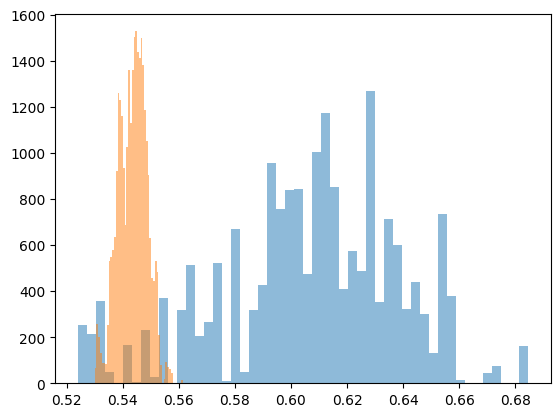

In [8]:
feature_to_plot = 5
plt.hist(Xs[:, feature_to_plot], bins=50, alpha=0.5)
plt.hist(Xt[:, feature_to_plot], bins=50, alpha=0.5)
plt.plot()

[]

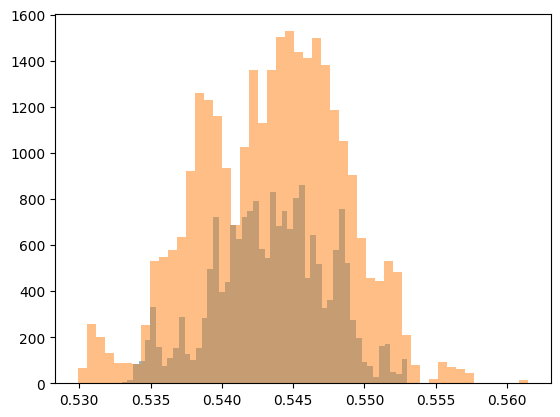

In [29]:
feature_to_plot = 5
plt.hist(transp_Xs_sinkhorn[:, feature_to_plot], bins=50, alpha=0.5)
plt.hist(Xt[:, feature_to_plot], bins=50, alpha=0.5)
plt.plot()

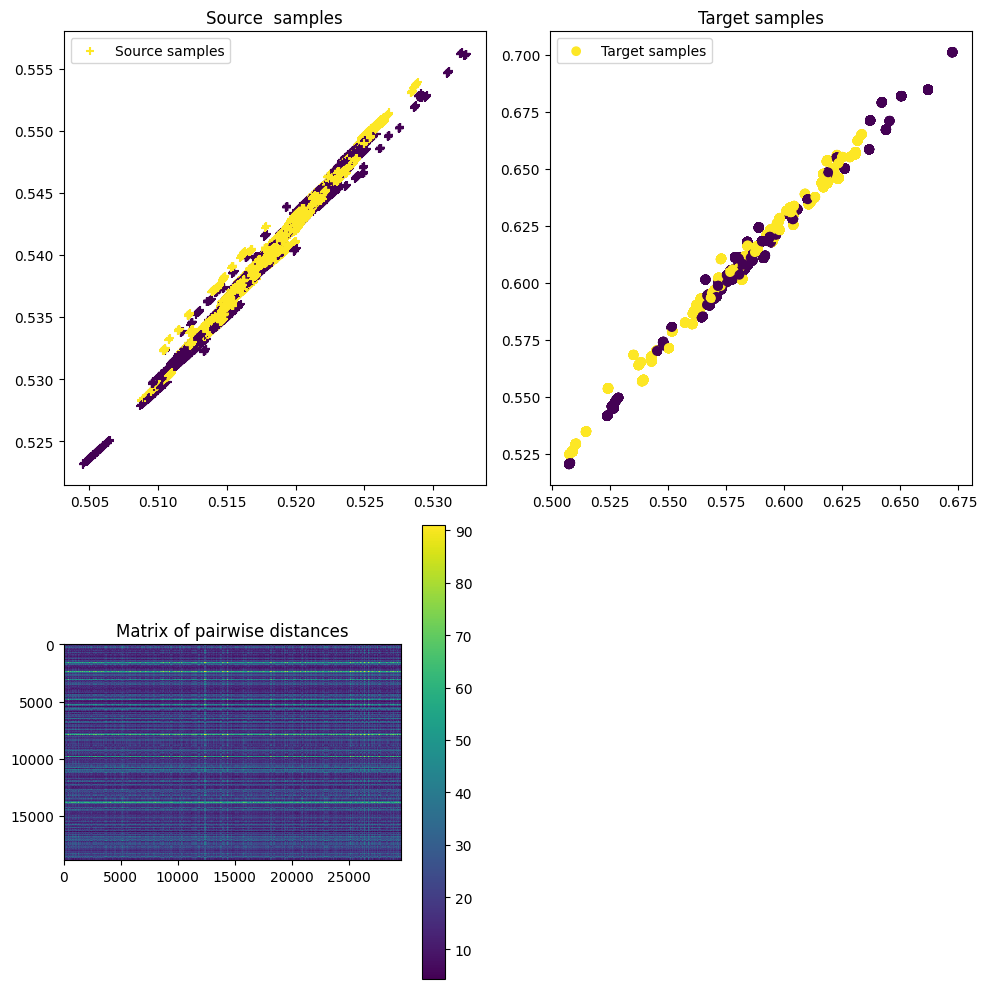

In [30]:
M = ot.dist(Xs, Xt, metric='sqeuclidean')

pl.figure(1, figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(X_nyu[:, 0], X_nyu[:, 1], c=y_nyu, marker='+', label='Source samples')
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(2, 2, 2)
pl.scatter(X_um1_train[:, 0], X_um1_train[:, 1], c=y_um1_train, marker='o', label='Target samples')
pl.legend(loc=0)
pl.title('Target samples')

pl.subplot(2, 2, 3)
pl.imshow(M, interpolation='nearest')
pl.colorbar()
pl.title('Matrix of pairwise distances')
pl.tight_layout()

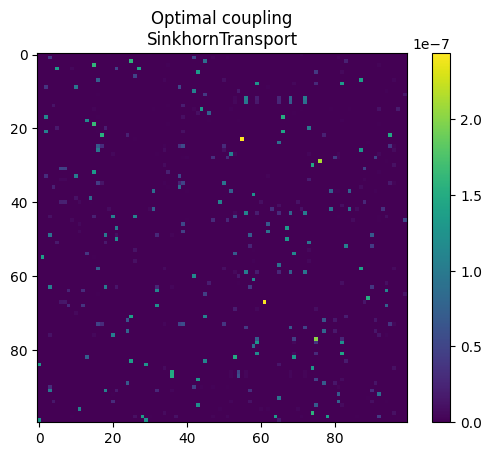

In [31]:
# pl.figure(2, figsize=(20, 10))

# pl.subplot(2, 3, 1)
# pl.imshow(ot_emd.coupling_, interpolation='nearest')
# pl.xticks([])
# pl.yticks([])
# pl.title('Optimal coupling\nEMDTransport')

# pl.subplot(2, 3, 2)
pl.imshow(ot_sinkhorn.coupling_[0:100, 0:100])
pl.title('Optimal coupling\nSinkhornTransport')
pl.colorbar()
plt.show()
# 
# pl.subplot(2, 3, 3)
# pl.imshow(ot_lpl1.coupling_, interpolation='nearest')
# pl.xticks([])
# pl.yticks([])
# pl.title('Optimal coupling\nSinkhornLpl1Transport')

# pl.subplot(2, 3, 4)
# ot.plot.plot2D_samples_mat(Xs, Xt, ot_emd.coupling_, c=[.5, .5, 1])
# pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
# pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
# pl.title('Main coupling coefficients\nEMDTransport')

# pl.subplot(2, 3, 5)
# ot.plot.plot2D_samples_mat(Xs, Xt, ot_sinkhorn.coupling_, c=[.5, .5, 1])
# pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
# pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
# pl.title('Main coupling coefficients\nSinkhornTransport')
# 
# pl.subplot(2, 3, 6)
# ot.plot.plot2D_samples_mat(Xs, Xt, ot_lpl1.coupling_, c=[.5, .5, 1])
# pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
# pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
# pl.title('Main coupling coefficients\nSinkhornLpl1Transport')
# pl.tight_layout()

# Transport the test samples

In [32]:
transformed_test = ot_sinkhorn.transform(Xs=X_um1_test)

print(f'Mean: {X_um1_test.mean()} -> {transformed_test.mean()}; target: {X_nyu.mean()}')
print(f'Std: {X_um1_test.std()} -> {transformed_test.std()}; target: {X_nyu.std()}')

Mean: 0.49186905902786715 -> 0.4365691991973963; target: 0.4364915038111768
Std: 0.17943448707812654 -> 0.1538620073486879; target: 0.15760476922505612


[]

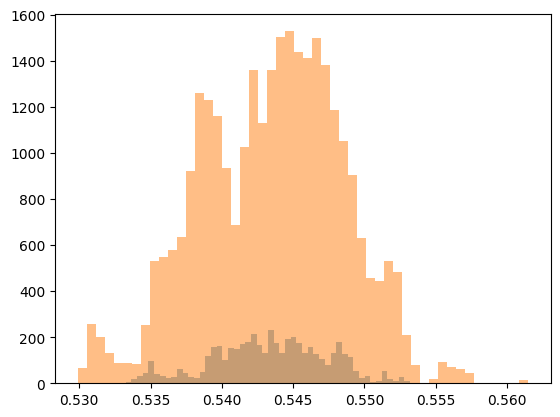

In [33]:
plt.hist(transformed_test[:, feature_to_plot], bins=50, alpha=0.5)
plt.hist(X_nyu[:, feature_to_plot], bins=50, alpha=0.5)
plt.plot()

# Train an SVM on NYU

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = SVC(kernel="rbf", C=1.0, class_weight='balanced', random_state=42, verbose=True)
model.fit(X=X_nyu, y=y_nyu)

[LibSVM]......
*
optimization finished, #iter = 6948
obj = -2785.389235, rho = -1.739781
nSV = 5595, nBSV = 3815
Total nSV = 5595


SVC(class_weight='balanced', random_state=42, verbose=True)

In [35]:
model.fit_status_ == 0

True

{'accuracy': 0.9999999999661865,
 'recall': 0.9999999999410863,
 'precision': 0.9999999999410863}

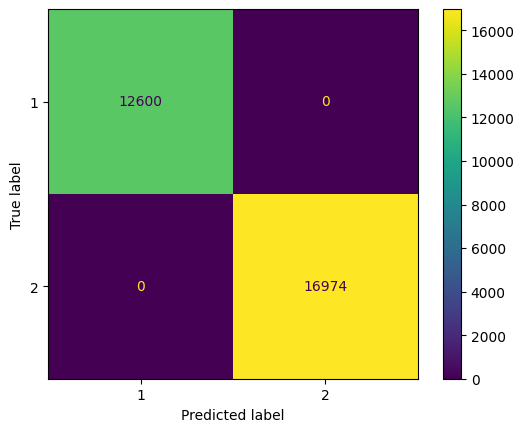

In [36]:
test_predictions = model.predict(X_nyu)
cm = confusion_matrix(y_nyu, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
metrics = {
    'accuracy': ((tp + tn) / (tp + tn + fp + fn + 1e-6)),
    'recall': (tp / (tp + fn + 1e-6)),
    'precision': (tp / (tp + fp + 1e-6))
}
metrics

{'accuracy': 0.4756355931195687,
 'recall': 0.181582840169533,
 'precision': 0.6520584320689795}

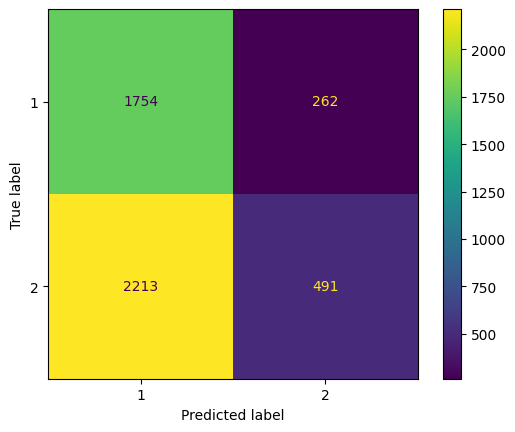

In [37]:
test_predictions = model.predict(X_um1_test)
cm = confusion_matrix(y_um1_test, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
metrics = {
    'accuracy': ((tp + tn) / (tp + tn + fp + fn + 1e-6)),
    'recall': (tp / (tp + fn + 1e-6)),
    'precision': (tp / (tp + fp + 1e-6))
}
metrics

{'accuracy': 0.5288135592099971,
 'recall': 0.7022928991485603,
 'precision': 0.5723327303880854}

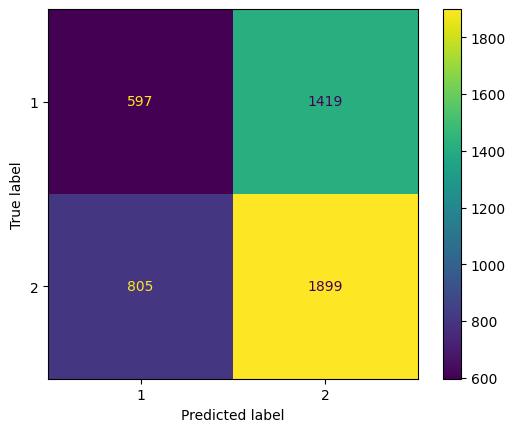

In [38]:
test_predictions = model.predict(transformed_test)
cm = confusion_matrix(y_um1_test, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
metrics = {
    'accuracy': ((tp + tn) / (tp + tn + fp + fn + 1e-6)),
    'recall': (tp / (tp + fn + 1e-6)),
    'precision': (tp / (tp + fp + 1e-6))
}
metrics